下面是目前训练的最强版本。

In [1]:
# -*- coding: utf-8 -*-
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle
print ("Ready OK.")

Using TensorFlow backend.


Ready OK.


In [3]:
env = Game()

INITIAL_RUN_NUMBER = 4 
INITIAL_MODEL_VERSION = 134
copyfile(run_archive_folder + env.name + '/run' + str(INITIAL_RUN_NUMBER).zfill(4) + '/config.py', './config.py')

import config

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural netwrok, set the weights from that model
if INITIAL_MODEL_VERSION != None:
    best_player_version  = INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, INITIAL_RUN_NUMBER, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())


#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
print ('Model loaded.')

LOADING MODEL VERSION 134...




In [4]:
def getNextBoard(board, playerTurn):
    # playerTurn 1, X; -1, O
    gs = GameState(np.array(board), playerTurn)

    preds = current_player.get_preds(gs)
    # print (preds)
    headValue = preds[0]
    qValue = preds[1]
    moves = preds[2]
    
    bestMove = np.argmax(qValue)
    assert len(np.where (moves ==bestMove)[0] == 1)
    newBoard = np.array(board)
    newBoard[bestMove] = playerTurn
    return newBoard

<IPython.core.display.Javascript object>


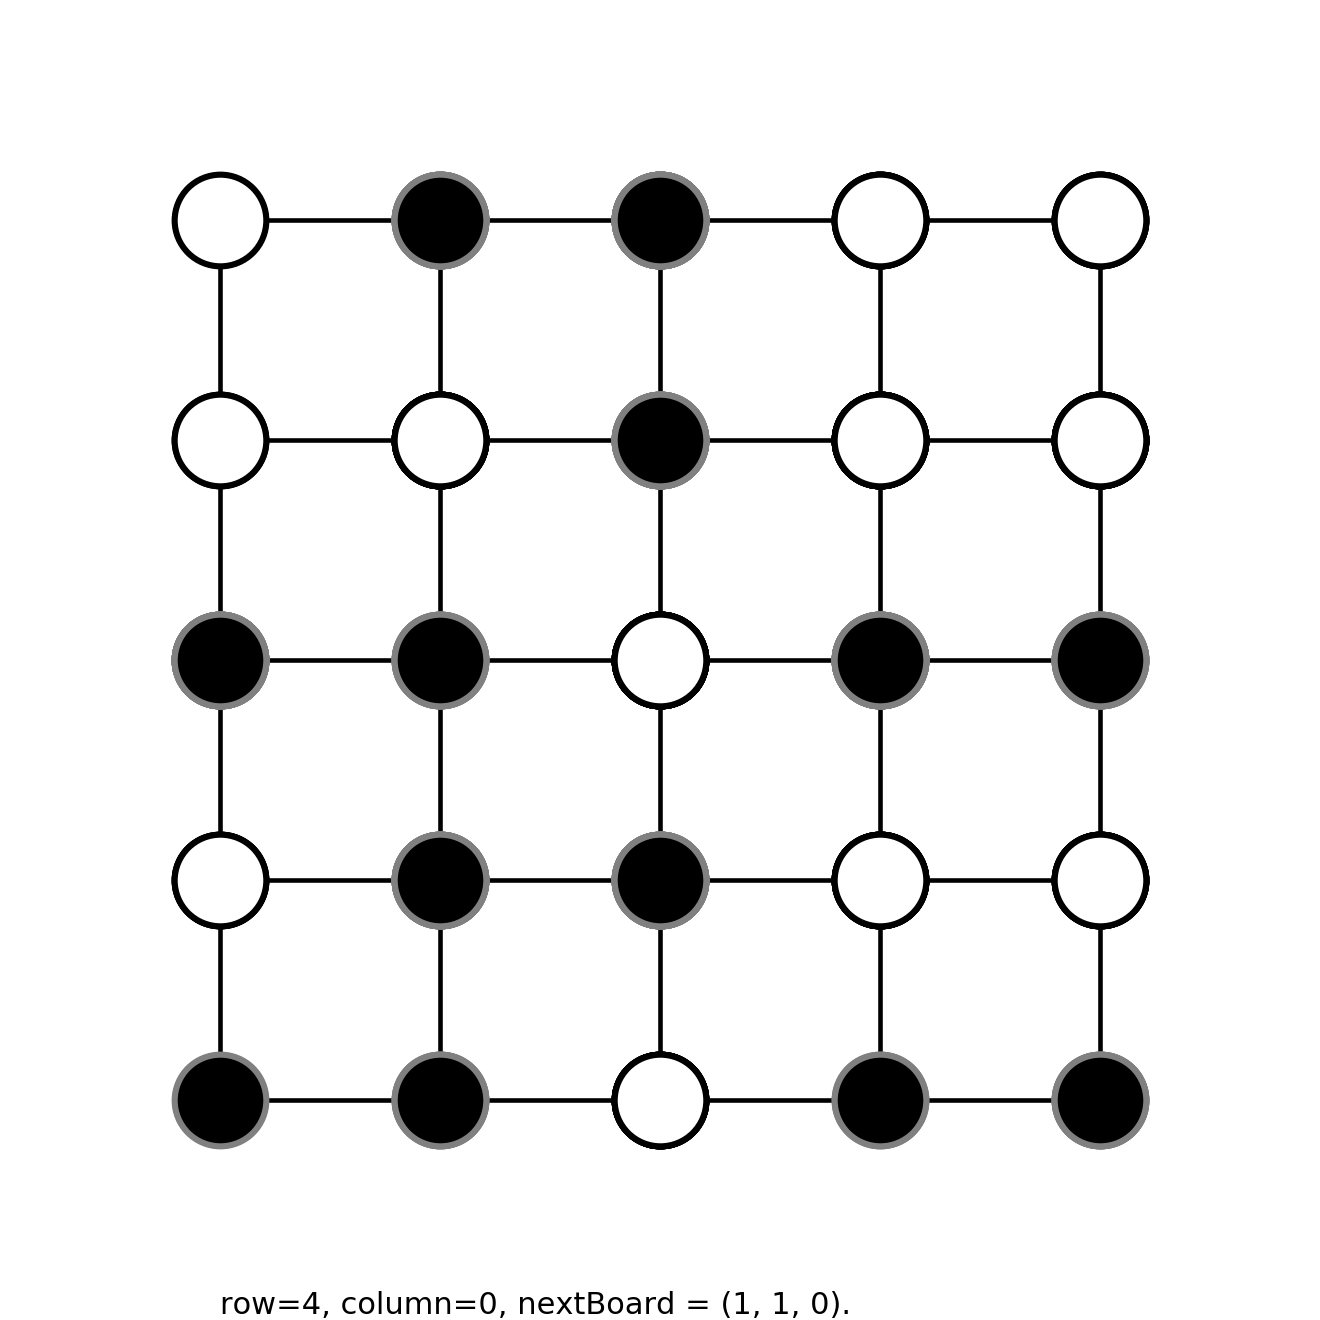

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


from game import GameState


initial = [
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
]

nextBoard = getNextBoard(initial, 1)

# create a 8" x 8" board
fig = plt.figure(figsize=[6,6])
fig.patch.set_facecolor((1,1,.8))

ax = fig.add_subplot(111)

# draw the grid
for x in range(5):
    ax.plot([x, x], [0,4], 'k')
for y in range(5):
    ax.plot([0, 4], [y,y], 'k')

# scale the axis area to fill the whole figure
ax.set_position([0,0,1,1])

# get rid of axes and everything (the figure background will show through)
ax.set_axis_off()

# scale the plot area conveniently (the board is in 0,0..18,18)
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
text=ax.text(0,-1, "", va="bottom", ha="left")

def drawBoard(board):
    # figBoard = np.flipud(np.array(board).reshape(5,5))
    figBoard = np.array(board).reshape(5,5)
    for row in range(5):
        for column in range(5):
            # print (i,j , figBoard[i][j])
            if figBoard[row][column] == -1:
                 ax.plot(column,row,'o',markersize=30, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=2)
            elif figBoard[row][column] == 1:
                 ax.plot(column,row,'o',markersize=30, markeredgecolor=(.5,.5,.5), markerfacecolor='k', markeredgewidth=2)

def onclick(event):
    row = round(event.ydata)
    column = round(event.xdata)

    s1, = ax.plot(column,row,'o',markersize=20, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=2)

    with open('boardFile.dump', 'rb') as the_file:
        aBoard = pickle.load(the_file)
        aBoard[ int(row * 5 + column) ] = -1
         
        newBoard = getNextBoard(aBoard, 1)
        drawBoard(newBoard)
        
        # show score
        gs = GameState(np.array(newBoard), -1)
        score = str(gs._getValue())
        tx = 'row=%d, column=%d, nextBoard = %s.' % (row, column, score)
        text.set_text(tx)
        
        with open('boardFile.dump', 'wb') as write_file:
            pickle.dump(newBoard, write_file)
    
    
   
    
    

# save board object to file
with open('boardFile.dump', 'wb') as the_file:
    pickle.dump(nextBoard, the_file)
    drawBoard(nextBoard)
cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [ ]:
# store objects? http://holoviews.org/user_guide/Plots_and_Renderers.html
